In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

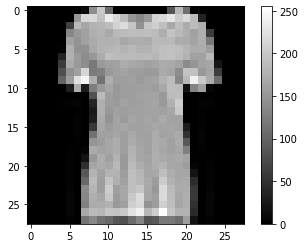

In [4]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

## Labels

In [5]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

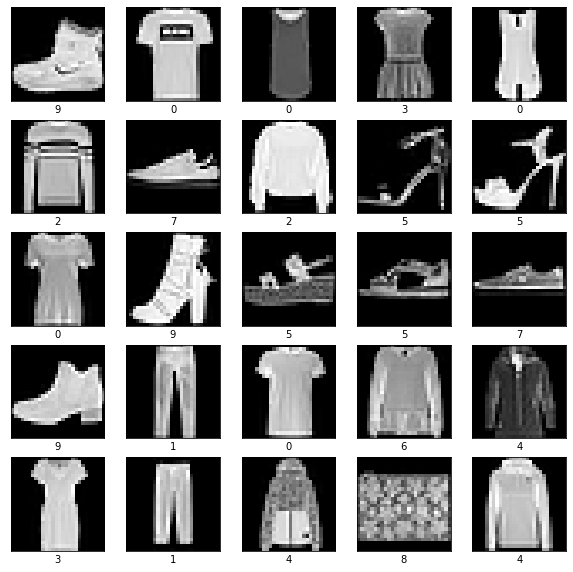

In [6]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard (agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

#### Filtrado de Información

Se elegirá para el ejercicio las siguientes tres clases:

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |

In [7]:
#Filtramos las clases que necesitamos
FiltroClasesTrain = [train_labels==0,train_labels==1,train_labels==2]
FiltroClasesTest  = [test_labels==0,test_labels==1,test_labels==2]
ValorAplicar = [True,True,True]
FiltroTrain=np.select(FiltroClasesTrain,ValorAplicar,False)
FiltroTest =np.select(FiltroClasesTest,ValorAplicar,False)

#Creamos los Arreglos Filtrados con las clases que usaremos
FTrain_images=train_images[FiltroTrain]
Ftrain_labels=train_labels[FiltroTrain]
Ftest_images =test_images[FiltroTest]
Ftest_labels=test_labels[FiltroTest]

#### Diccionario Labels 
Definición del diccionario númerico para almacenar el label correspondiente al valor númerico.

In [8]:
##Aunque solo usaremos tres, se dejara en el diccionario todas las clases
labels = {0: "T-shirt/top",1:"Trouser",2: "Pullover",3: "Dress",4:"Coat",5:"Sandal",6: "Shirt",7:"Sneaker",8:"Bag",9:"Ankle boot"}

### Modelo en Tensorflow

Habilitamos la compatibilidad con las funciones de la v1 de Tensorflow

In [10]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Enabled compatitility to tf1.x


Modelo en Tensorflow; para este modelo no se usaran Interceptos (Bias)

In [30]:
import time
from sklearn.preprocessing import OneHotEncoder

def Entrenamiento(learning_rate,epochs,imprimir_cada,batch_size,x,y,x_test,y_test):
    
    #Determinamos el Total de Iteraciones - Para MiniBatch - Gradient Descent
    total_iteraciones = int(x.shape[0]/batch_size)
    
    #El Número de Features se determinará por las columnas enviadas en x + 1 (intercepto -> Si así deseamos)
    features=x.shape[1]*x.shape[2]
    
    ##One Hot Encode - Para la Transformación de la Variable Dependiente Y
    ##Data Train
    encoder = OneHotEncoder()
    y=encoder.fit_transform(y.reshape(-1,1))
    y=y.toarray()
    ##Data Test
    y_test=encoder.fit_transform(y_test.reshape(-1,1))
    y_test=y_test.toarray()
    
    
    #En Base a las columnas Y, es el Número de Labels a Procesar
    numlabels=y.shape[1]
    
    #Limpiamos cualquier variable o operación en el grafo 
    tf.reset_default_graph()

    ##Definimos los Tensores para la Inicialización de Variables
    with tf.name_scope("Inicializacion"):
        init_global = tf.compat.v1.global_variables_initializer()
        init_local = tf.compat.v1.local_variables_initializer()
        init = tf.group(init_global,init_local)

    string_conf= time.strftime("%Y%m%d") + "_"+time.strftime("%H%M%S")+"_MiniBatch_GD_Lr="+str(learning_rate)+"_BatchSize="+str(batch_size)

    #Parametros que entrenará el Modelo - Pendiente e Intercepto
    #weights = tf.Variable(tf.zeros([features,numlabels]),name="parametros")
    #Tengo mejores resultados partiendo en zero - Por lo que lo dejo de esta forma
    weights = tf.Variable(tf.zeros([features,numlabels]),name="parametros")
    
    #Definimos los Placeholders que almacenarán los datos de Entrenamiento del Modelo
    tensor_x = tf.placeholder(tf.float32,[None,features],name="Data_x")
    Labels_y = tf.placeholder(tf.float32,  [None,numlabels],name="Labels")

    ##Nuestra función de Hipotesis - con Logits
    logits = tf.matmul(tensor_x,weights,name="Prediccion_Modelo")

    ##Función de Costo -  Error
    with tf.name_scope("Error"):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=Labels_y))

    with tf.name_scope("Calculo_Gradiente"):
        gradiente = tf.gradients(loss,weights)

    #Actualización de Variables del Modelo - Definición Tensores
    with tf.name_scope("Act_Parametros_Modelo"):
        actualizacion_parametros = tf.assign(weights, weights - learning_rate* gradiente[0] )

    #Creamos el Tensor con la Información del Scalar
    Loss_summary = tf.summary.scalar(name='Loss_Function', tensor=loss)
    
    # Definimos - accuracy
    with tf.name_scope("Accuracy"):
        # The default threshold is 0.5, rounded off directly
        prediction = tf.round(tf.nn.softmax(logits))
        # Bool into float32 type
        correct = tf.cast(tf.equal(prediction, Labels_y), dtype=tf.float32)
        # Promedio de los aciertos
        accuracy = tf.reduce_mean(correct)
    
    #Creamos el Tensor con la Información del Scalar
    Accuracy_summary = tf.summary.scalar(name='Accuray_Function', tensor=accuracy)
    
    #Iniciamos con una Sesión Monitoreada - Para el Entrenamiento del Modelo
    with tf.train.MonitoredSession() as session:

        # Inicialización de variables Globales y locales
        session.run(init)

        #Escritura del Grafo para Tensorboard
        writer = tf.summary.FileWriter('./graphs/'+string_conf, session.graph)

        #Entrenamiento del Modelo
        for step in range(epochs):
            
            for i in range(total_iteraciones):  #muchas iteraciones por epoch 
                ##Armamos el Batch que corresponde a la iteración
                muestra_inicio = i*batch_size
                muestra_fin = muestra_inicio + batch_size
                x_train =  x[muestra_inicio:muestra_fin]
                y_train =  y[muestra_inicio:muestra_fin]
                
                #Creamos el Diccionario que le dará valor a los Placeholders
                feed_dict = {tensor_x:np.array(x_train).reshape(-1,features), Labels_y:np.array(y_train).reshape(-1,numlabels)}

                #Ejecutamos el Grafo - Actualización de Datos
                session.run(actualizacion_parametros,feed_dict=feed_dict)

            #Ejecutamos el Grafo - Predicción del Modelo - Cálculo de Logits
            #logits_predict = session.run(logits,feed_dict=feed_dict)
            
            # La Perdida y Accuracy despues de la iteración completa de los MiniBatch se probará sobre el data set completo
            feed_dict = {tensor_x:np.array(x).reshape(-1,features), Labels_y:np.array(y).reshape(-1,numlabels)}
            
            #Ejecutamos el Grafo - Predicción del Modelo
            perdida = session.run(loss,feed_dict=feed_dict)

            #Ejecutamos el Grafo - Resultado de Variables Entrenadas
            pesos_calculados = session.run(weights,feed_dict=feed_dict)

            #Ejecutamos el Grafo - Resultado de Variables Entrenadas
            accuracy_results = session.run(accuracy,feed_dict=feed_dict)

            #Ejecutamos el Grafo - Datos Escalar - Loss
            summaryLoss = session.run(Loss_summary,feed_dict=feed_dict)

            #Almacenamos datos de Scalar - Para Tensorboard
            writer.add_summary(summaryLoss, step)
            
            #Ejecutamos el Grfo - Dato Escalar - Acurracy
            accuracy_scalar = session.run(Accuracy_summary,feed_dict=feed_dict)
            
            #Almacenamos datos de Scalar - Para Tensorboard
            writer.add_summary(accuracy_scalar, step)

            #Imprimimos resultados de Variables por entrenamiento - Cada N Entrenamientos
            if (step+1) % imprimir_cada == 0:
                print("Prueba {} - Error:{} Accuracy:{}".format(step+1,perdida,accuracy_results))
                
        # Probamos el Modelo Entrenado con los datos completos - Train
        feed_dict = {tensor_x:np.array(x).reshape(-1,features), Labels_y:np.array(y).reshape(-1,numlabels)}
        final_error = session.run(loss,feed_dict=feed_dict)
        final_accuracy= session.run(accuracy,feed_dict=feed_dict)
        print("Data Train - Despues de Entrenamiento Error={} Accuracy={}".format(final_error,final_accuracy))
        
        # Probamos el Modelo Entrenado con los datos completos - Test
        feed_dict = {tensor_x:np.array(x_test).reshape(-1,features), Labels_y:np.array(y_test).reshape(-1,numlabels)}
        final_error = session.run(loss,feed_dict=feed_dict)
        final_accuracy= session.run(accuracy,feed_dict=feed_dict)
        print("Data Test - Despues de Entrenamiento Error={} Accuracy={}".format(final_error,final_accuracy))
        
        ##Devolvemos los pesos obtenidos
        return pesos_calculados

#### Entrenamos Nuestra Función de Entrenamiento (Datas sin Normalización)

En el inciso anterior definimos el Modelo y la función de Entrenamiento, ahorita procedemos a entrar nuestro modelo sin modificación de los datos (Normalización/Scaling).

In [35]:
##Seteamos el Arreglo de las Variables Dependientes
x = FTrain_images
x_test = Ftest_images

##Seteamos el Arreglo de la Variable Independiente
y= np.array(Ftrain_labels).reshape(-1,1)
y_test = np.array(Ftest_labels).reshape(-1,1)

##Seteamos los datos que enviaremos a la función de Entrenamiento
BatchSize=32
learning_rate=0.001
epochs=50
imprimir_cada=5

#Entrenamos nuestro modelo con los parametros enviados
weights=Entrenamiento(learning_rate,epochs,imprimir_cada,BatchSize,x,y,x_test,y_test)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Prueba 5 - Error:2.162191867828369 Accuracy:0.9756666421890259
Prueba 10 - Error:2.3027493953704834 Accuracy:0.974407434463501
Prueba 15 - Error:2.0358715057373047 Accuracy:0.9784073829650879
Prueba 20 - Error:1.7245310544967651 Accuracy:0.9802963137626648
Prueba 25 - Error:1.332382082939148 Accuracy:0.9820370078086853
Prueba 30 - Error:2.034933090209961 Accuracy:0.9784073829650879
Prueba 35 - Error:1.4603315591812134 Accuracy:0.981333315372467
Prueba 40 - Error:1.3231247663497925 Accuracy:0.9818333387374878
Prueba 45 - Error:1.8323155641555786 Accuracy:0.9812222123146057
Prueba 50 - Error:1.343745231628418 Accuracy:0.9835000038146973
Data Train - Despues de Entrenamiento Error=1.343745231628418 Accuracy=0.9835000038146973
Data Test - Despues de Entrenamiento Error=2.552340269088745 Accuracy=0.972000002861023


Nuestro Modelo ya esta entrenado y ya tenemos los pesos en la variable **weights** que nos servirán para la función de predicción.

In [38]:
weights.shape

(784, 3)

##### Tensorboard - Grafo
Vemos como quedo nuestro Grafo en Tensorboard, de acuerdo al modelo definido.

<img src="assets/Grafo_Tensorboard_RL.png">

##### Tensorboard - Scalars (Loss / Accuracy)
En Tensorboard podemos ver los valores para los Escalares Loss (Perdida) y Accuracy (Exactitud)

<img src="assets/Scalars_Tensorboard_RL.png">

### Función para Predicción de Imagen

Se creará una función que reciba de entrada el tensor que representa a una imagen; graficando esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.

In [83]:
##Para la función de Predicción, ya no usaremos Tensorflow, dado que ya con nuestro modelo de entrenamiento 
##ya determinamos los pesos que nos servirán para calcular los logits, y podemos usar una función de softmax de python

#Libreria para la implementación de Softmax
from scipy.special import softmax

def PrediccionImagen(Imagen):
    #Con reshape modificamos la imagen como la vamos a procesar
    Tensor_Imagen= np.array(Imagen).reshape(1,Imagen.shape[0]*Imagen.shape[1])
    #Determinamos los logits
    logits= np.matmul(Tensor_Imagen, weights)
    #Determinamos la predicción con Softmax
    predict = softmax(logits)
    ##El Label final es la posición con el valor mas alto
    label_result= np.argmax(predict)
    
    ##Mostramos la Imagen
    plt.imshow(Imagen, cmap = 'gray')
    plt.colorbar()
    ##Mostramos la descripción de la prenda usando el Diccionario de Datos
    plt.xlabel(labels[label_result])
    plt.show()
    
    ##Devolvemos la probabilidad para la opcion seleccionada
    return predict[0,label_result]

Probamos nuestra función con una imagen random

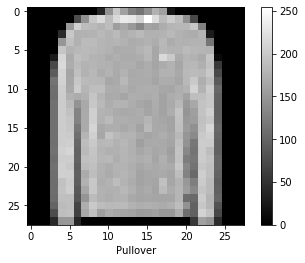

Función de Probabilidad Imagen:1.0


In [84]:
ProbImg=PrediccionImagen(FTrain_images[20])
print("Función de Probabilidad Imagen:{}".format(ProbImg))

### Prueba Función de Predicción

Se Utilizará la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)

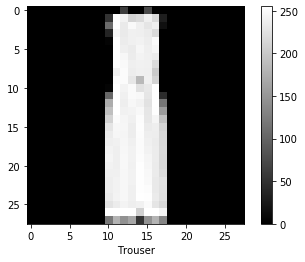

Función de Probabilidad Imagen:1.0
Label Real -> Trouser


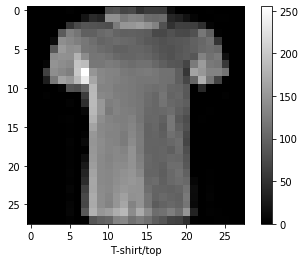

Función de Probabilidad Imagen:1.0
Label Real -> T-shirt/top


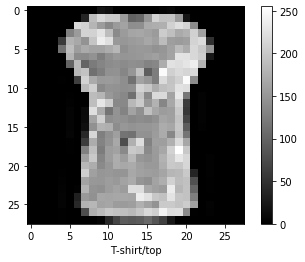

Función de Probabilidad Imagen:1.0
Label Real -> T-shirt/top


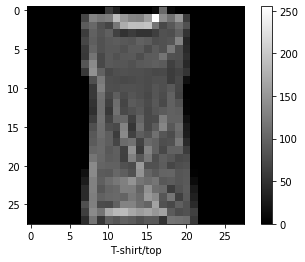

Función de Probabilidad Imagen:1.0
Label Real -> T-shirt/top


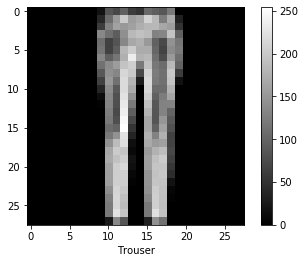

Función de Probabilidad Imagen:1.0
Label Real -> Trouser


In [98]:
#Función para generar los números random
import random 

##Se escogeran al azar 5 prendas dentro del Dataset de Pruebas,para probar la función de Predicción
for i in range(0,5):
    num = random.randint(0, Ftest_images.shape[0]-1)
    
    ##La pasamos por la función de Prueba
    ProbImg=PrediccionImagen(Ftest_images[num])
    print("Función de Probabilidad Imagen:{}".format(ProbImg))
    
    ##Vemos que Label tenia - para comparar
    print("Label Real -> {}".format(labels[Ftest_labels[num]]))

### Entrenamiento con Datos Transformados

Ahora que ya usamos los datos crudos, haremos el entrenamiento del modelo con datos transformados y veremos el efecto en la curva de aprendizaje.

In [108]:
# Definiremos una función para normalizar los datos
def min_max_normalized(data, set,col_max,col_min):
    if set: ##Mandaremos por parametros si deseamos setear los parametros de los datos maximos y minimos por columna
        col_max = np.max(data, axis=0)
        col_min = np.min(data, axis=0)
    return np.divide(data - col_min, col_max - col_min),col_max,col_min

Aplicamos la normalización a los datos antes de mandar al modelo de entrenamiento

In [116]:
##Seteamos el Arreglo de las Variables Dependientes
##Normalizamos los datos de entrenamiento
col_max=0
col_min=0
x,col_max,col_min = min_max_normalized(FTrain_images,True,col_max,col_min)
#Para normalizar los datos de Prueba, se mandan los parametros usados en la normalización del modelo de entrenamiento
x_test,col_max,col_min = min_max_normalized(Ftest_images,False,col_max,col_min) 

##Seteamos el Arreglo de la Variable Independiente
y= np.array(Ftrain_labels).reshape(-1,1)
y_test = np.array(Ftest_labels).reshape(-1,1)

##Seteamos los datos que enviaremos a la función de Entrenamiento
BatchSize=32
learning_rate=0.001
epochs=50
imprimir_cada=5

#Entrenamos nuestro modelo con los parametros enviados
weights=Entrenamiento(learning_rate,epochs,imprimir_cada,BatchSize,x,y,x_test,y_test)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Prueba 5 - Error:0.2062428891658783 Accuracy:0.9639258980751038
Prueba 10 - Error:0.17673036456108093 Accuracy:0.9668889045715332
Prueba 15 - Error:0.16310381889343262 Accuracy:0.968407392501831
Prueba 20 - Error:0.15444350242614746 Accuracy:0.9695555567741394
Prueba 25 - Error:0.14821021258831024 Accuracy:0.9701666831970215
Prueba 30 - Error:0.1434221714735031 Accuracy:0.9709073901176453
Prueba 35 - Error:0.13959169387817383 Accuracy:0.9717222452163696
Prueba 40 - Error:0.13643822073936462 Accuracy:0.9724259376525879
Prueba 45 - Error:0.13378487527370453 Accuracy:0.9728147983551025
Prueba 50 - Error:0.13151317834854126 Accuracy:0.9732407331466675
Data Train - Despues de Entrenamiento Error=0.13151317834854126 Accuracy=0.9732407331466675
Data Test - Despues de Entrenamiento Error=0.1429516077041626 Accuracy=0.9691110849380493


Veamos en Tensorboard, la diferencia entre los valores de perdida (loss) y Exactitud (Accuracy).

<img src="assets/Scalars_Tensorboard_RL_NOR.png">

#### Resultados Preliminares - Data Transformada

Puedo concluir lo siguiente:
* Usando los mismos parametros que usamos con los datos crudos, conseguimos un costo(Loss) mucho más bajo, pero el nivel de Exactitud (Accuracy) es un poco menor.
* Aunque la Exactitud (Accuracy) es un poco menor, vemos que la curva es mucho más estable, por lo que se ve que el modelo es mucho más estable en los cálculos.
* El Costo es menor, y al centrarnos solo en sú grafica, vemos que tambien la curva es mucho más estable que usando los datos crudos. Veamos la gráfica:
<img src="assets/Only_Loss_Function_NOR.png">


#### Optimización de Resultados - Data Transformada

Para mejorar los resultados obtenidos con la data transformada, vamos variando el learning rate para ajustarlo nuestro modelo.

In [118]:
##Seteamos los datos que enviaremos a la función de Entrenamiento
BatchSize=32
learning_rate=0.5
epochs=50
imprimir_cada=5

#Entrenamos nuestro modelo con los parametros enviados
weights=Entrenamiento(learning_rate,epochs,imprimir_cada,BatchSize,x,y,x_test,y_test)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Prueba 5 - Error:0.20209740102291107 Accuracy:0.9771666526794434
Prueba 10 - Error:0.16893450915813446 Accuracy:0.9794814586639404
Prueba 15 - Error:0.1239405944943428 Accuracy:0.9828518629074097
Prueba 20 - Error:0.13207577168941498 Accuracy:0.9824259281158447
Prueba 25 - Error:0.11397798359394073 Accuracy:0.9837407469749451
Prueba 30 - Error:0.10941949486732483 Accuracy:0.9842592477798462
Prueba 35 - Error:0.10841074585914612 Accuracy:0.9837592840194702
Prueba 40 - Error:0.10111212730407715 Accuracy:0.9844259023666382
Prueba 45 - Error:0.09697975218296051 Accuracy:0.9844629764556885
Prueba 50 - Error:0.09520693123340607 Accuracy:0.9846110939979553
Data Train - Despues de Entrenamiento Error=0.09520693123340607 Accuracy=0.9846110939979553
Data Test - Despues de Entrenamiento Error=0.18659891188144684 Accuracy=0.973111093044281


#### Visualización de Mejora en Tensorboard

Aunque no se mostro arriba, pero se probaron con varios learning rate, hasta encontrar que el mejor es de 0.5. 

Veamos como el Escalar -> Exactitud (Accuracy) fue mejorando cambiando los learning rate.

<img src="assets/Scalars_Tensorboard_Accuracy_NOR.png">

Veamos como el Escalar -> Loss (Perdida/Costo) fue mejorando cambiando los learning rate.

<img src="assets/Scalars_Tensorboard_LOSS_NOR.png">



#### Conclusiones Entrenamiento Modelos - Data Transformada

Según mis pruebas puedo concluir lo siguiente:
* Provee una mejor estabilidad en el entrenamiento de la función.
* Se obtienen mejores resultados, ya que reducimos la variabilidad de los datos.